1st try into Keras.  
Almost a copy of this blog post about dogs vs cats classification: "Building powerful image classification models using very little data"
https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d
    

In [32]:
import os
print 'OMP_NUM_THREADS',os.environ['OMP_NUM_THREADS']
%run 'statefarm-util.ipynb'

OMP_NUM_THREADS 2
Found 19390 images belonging to 10 classes.
Found 3034 images belonging to 10 classes.
v5
running statefarm-predict as main. doing nothing


In [33]:
#TODOs for next-chapter
# read http://cs231n.github.io/neural-networks-2/ and do it point by point
# Initiation: the current recommendation is to use ReLU units and use the w = np.random.randn(n) * sqrt(2.0/n), as discussed in He et al..
#           model.add(Dense(64, init='he_normal'))
# Normalization:
#   The recommended preprocessing is to center the data to have mean of zero, and normalize its scale to [-1, 1] along each feature
#   done via pre-processing...
#   It is most common to use a single, global L2 regularization strength that is cross-validated. 
#      from keras.regularizers import l2, activity_l2
#      model.add(Dense(64, input_dim=64, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
#   It is also common to combine this with dropout applied after all layers.
#      The value of p=0.5  is a reasonable default, but this can be tuned on validation data.
#   Batch-norm between the conv/dense layer and the relu -> FOR NOW IT IS OUT , to save time
# Activation: 
#   PReLU and LeakyReLU, probably leakyRelu. see http://keras.io/layers/advanced-activations/ alpha value is
#   super criticla in one paper 5.5 . although in keras default is 0.3
#    model.add(Activation(LeakyReLU(alpha=5.5)) )  default is 0.3 NOT SURE WHAT IS BETTER
# optimizers: The two recommended updates to use are either SGD+Nesterov Momentum or Adam.


#
#  other: tune the dropout 0.5
#  Batch-norm between the conv/dense layer and the relu -> FOR NOW IT IS OUT , to save time
#  
# change optimizer to SGD_ Nesterov

# PROBLEM: compiling the model with leakyrelu fucked us with "Overriding existing lock by dead process" 


# Time: 150x150 (32,3,3) (32,3,3) (64,3,3) -> Dense(1-3xN) -> dropout0.5-> dense10

# init  BN   Relu    Dense  Reg_W reg_A  Dropout  OMP  Time#1024  
##########################################################################
# he_n  No   Yes     1x50    L2     L2    0.5     8   57-60s    (50-60% cpu)
# he_n  No   Yes     1x50    L2     L2    0.5     4   64-67s     
# he_n  No   Yes     1x50    L2     L2    0.5     3   62-65s    (50-60% cpu)
# he_n  No   Yes     1x50    L2     L2    0.5     2   57-59s     (40-44% cpu)  <---best and using less CPU
# he_n  No   Yes     1x50    L2     L2    0.5     1   72-77s            
# he_n  Yes  Yes     1x50    L2     L2    0.5     1   153-156s  (100% BN more than doubles the time!)
#                                                               Note BN cost is on the biggest layer(1st between conv and dense)
# he_n  Yes  Yes     1x50    No     No    0.5     1   146-151s  (5% cost to add W+A Regulation)
# he_n  No   Yes     1x50    No     No    No      1   67-70s    (7% cost to add Dropout)
# he_n  No   Yes     3x50    No     No    No      1   67-69s
# he_n  No   Yes     3x200   No     No    No      1   71-73s     (6% to make the Dense layer 50->200)
# Model we shall use:
# he_n  Half  Yes      3x200   L2     L2    0.5     2             BN-not on the biggest layer

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense ,BatchNormalization
from keras.regularizers import l2, activity_l2
from keras.layers.advanced_activations import LeakyReLU
                                                                                      
def define_model():
    init='he_normal'
    W_regularizer=l2(0.01)
    activity_regularizer=activity_l2(0.01)
    
    def addBN():
        model.add(BatchNormalization())
    
    def addActivation():
        model.add(Activation('relu'))   #model.add(Activation(LeakyReLU(alpha=5.5)) )
    
    def addDropout():
        model.add(Dropout(0.5))
    
    def addDense():
        model.add(Dense(200,init=init,  W_regularizer=W_regularizer, activity_regularizer=activity_regularizer))
        #addBN() ###########################################NO BN IN THIS LEVEL ################################
        addActivation()
        model.add(Dense(200,init=init, W_regularizer=W_regularizer, activity_regularizer=activity_regularizer))
        addBN()
        addActivation()
        model.add(Dense(200,init=init,    W_regularizer=W_regularizer, activity_regularizer=activity_regularizer))
        addBN()
        addActivation()
   
    
    model = Sequential()
    
    model.add(Convolution2D(32, 3, 3, input_shape=(3, img_width, img_height),init=init,
                            W_regularizer=W_regularizer, activity_regularizer=activity_regularizer))
    addBN()
    addActivation()
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Convolution2D(32, 3, 3,init=init,  W_regularizer=W_regularizer, activity_regularizer=activity_regularizer))
    addBN()
    addActivation()
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3,init=init,  W_regularizer=W_regularizer, activity_regularizer=activity_regularizer))
    addBN()
    addActivation()
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    addDense()
    addDropout()
    
    model.add(Dense(10,init=init) ) 
    model.add(Activation('softmax'))   
    return model





model started from scratch
model model3_optimization_test compiled
Epoch 1/1
5120/5120 [==============================] - 699s - loss: 18.1189 - acc: 0.2369 - val_loss: 2.1892 - val_acc: 0.3574
Saved model to disk model_chapter3_0epoc
Epoch 1/1
5120/5120 [==============================] - 765s - loss: 7.5443 - acc: 0.4570 - val_loss: 1.5257 - val_acc: 0.4697
Saved model to disk model_chapter3_1epoc
Epoch 1/1
5120/5120 [==============================] - 689s - loss: 3.5896 - acc: 0.6488 - val_loss: 1.9699 - val_acc: 0.3590
Saved model to disk model_chapter3_2epoc
Epoch 1/1
5118/5120 [============================>.] - ETA: 0s - loss: 1.8991 - acc: 0.7614

C:\Python27\Anaconda2\1\lib\site-packages\keras\engine\training.py:1403: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


5150/5120 [==============================] - 697s - loss: 1.8959 - acc: 0.7616 - val_loss: 1.8912 - val_acc: 0.3887
Saved model to disk model_chapter3_3epoc
Epoch 1/1
5120/5120 [==============================] - 707s - loss: 1.2178 - acc: 0.7992 - val_loss: 1.5978 - val_acc: 0.4756
Saved model to disk model_chapter3_4epoc
Epoch 1/1
5120/5120 [==============================] - 710s - loss: 0.9396 - acc: 0.8277 - val_loss: 1.6677 - val_acc: 0.5829
Saved model to disk model_chapter3_5epoc
Epoch 1/1
5120/5120 [==============================] - 702s - loss: 0.8008 - acc: 0.8520 - val_loss: 1.9146 - val_acc: 0.5781
Saved model to disk model_chapter3_6epoc
Epoch 1/1
5150/5120 [==============================] - 707s - loss: 0.6810 - acc: 0.8798 - val_loss: 1.3611 - val_acc: 0.5752
Saved model to disk model_chapter3_7epoc
Epoch 1/1
5120/5120 [==============================] - 707s - loss: 0.6647 - acc: 0.8748 - val_loss: 1.8251 - val_acc: 0.5314
Saved model to disk model_chapter3_8epoc
Epoch 1/

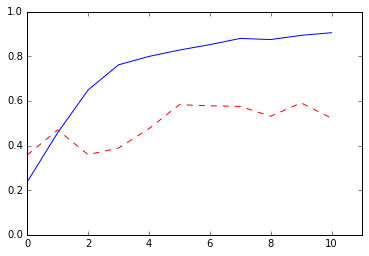

Epoch 1/1
5120/5120 [==============================] - 722s - loss: 0.5475 - acc: 0.9109 - val_loss: 2.1834 - val_acc: 0.4419
Saved model to disk model_chapter3_11epoc
Epoch 1/1
5120/5120 [==============================] - 705s - loss: 0.5673 - acc: 0.9082 - val_loss: 1.8477 - val_acc: 0.4600
Saved model to disk model_chapter3_12epoc
Epoch 1/1
5120/5120 [==============================] - 707s - loss: 0.5082 - acc: 0.9176 - val_loss: 2.2941 - val_acc: 0.4043
Saved model to disk model_chapter3_13epoc
Epoch 1/1
5150/5120 [==============================] - 710s - loss: 0.4938 - acc: 0.9202 - val_loss: 2.1838 - val_acc: 0.5295
Saved model to disk model_chapter3_14epoc
Epoch 1/1
5120/5120 [==============================] - 706s - loss: 0.5213 - acc: 0.9145 - val_loss: 1.5651 - val_acc: 0.5869
Saved model to disk model_chapter3_15epoc
Epoch 1/1
5120/5120 [==============================] - 705s - loss: 0.4936 - acc: 0.9201 - val_loss: 2.4939 - val_acc: 0.4004
Saved model to disk model_chapter3

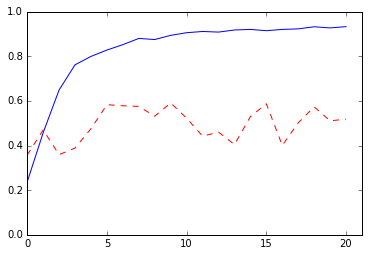

Epoch 1/1
5150/5120 [==============================] - 763s - loss: 0.4078 - acc: 0.9400 - val_loss: 1.3626 - val_acc: 0.5693
Saved model to disk model_chapter3_21epoc
Epoch 1/1
5120/5120 [==============================] - 722s - loss: 0.4284 - acc: 0.9291 - val_loss: 2.0113 - val_acc: 0.5086
Saved model to disk model_chapter3_22epoc
Epoch 1/1
5120/5120 [==============================] - 714s - loss: 0.3989 - acc: 0.9387 - val_loss: 1.9385 - val_acc: 0.5098
Saved model to disk model_chapter3_23epoc
Epoch 1/1
5150/5120 [==============================] - 2382s - loss: 0.4078 - acc: 0.9373 - val_loss: 1.8410 - val_acc: 0.5400
Saved model to disk model_chapter3_24epoc
Epoch 1/1
5120/5120 [==============================] - 993s - loss: 0.3980 - acc: 0.9428 - val_loss: 1.8887 - val_acc: 0.5914
Saved model to disk model_chapter3_25epoc
Epoch 1/1
5120/5120 [==============================] - 1028s - loss: 0.3684 - acc: 0.9473 - val_loss: 1.7394 - val_acc: 0.5029
Saved model to disk model_chapte

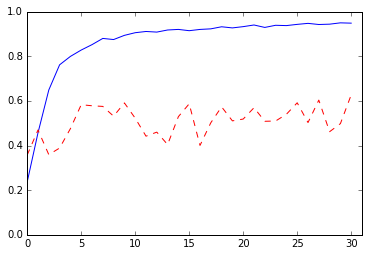

Epoch 1/1
5120/5120 [==============================] - 717s - loss: 0.3455 - acc: 0.9500 - val_loss: 2.3947 - val_acc: 0.5114
Saved model to disk model_chapter3_31epoc
Epoch 1/1
5150/5120 [==============================] - 24173s - loss: 0.3930 - acc: 0.9396 - val_loss: 1.5705 - val_acc: 0.5625
Saved model to disk model_chapter3_32epoc
Epoch 1/1
5120/5120 [==============================] - 817s - loss: 0.3443 - acc: 0.9473 - val_loss: 2.4171 - val_acc: 0.4336
Saved model to disk model_chapter3_33epoc
Epoch 1/1
5120/5120 [==============================] - 845s - loss: 0.3496 - acc: 0.9543 - val_loss: 1.3599 - val_acc: 0.6429
Saved model to disk model_chapter3_34epoc
Epoch 1/1
5150/5120 [==============================] - 1074s - loss: 0.3748 - acc: 0.9466 - val_loss: 1.6353 - val_acc: 0.5996
Saved model to disk model_chapter3_35epoc
Epoch 1/1
5120/5120 [==============================] - 1080s - loss: 0.3333 - acc: 0.9549 - val_loss: 1.8688 - val_acc: 0.5459
Saved model to disk model_chap

KeyboardInterrupt: 

In [35]:
nb_train_samples = 5*1024   #1/4 of epoc
nb_validation_samples = 1*1024


model = define_model()
print 'model started from scratch'
model_name = 'model3_optimization_test'
#model=loadFromFiles(model_name)
#print 'model',model_name,'loaded'
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print 'model',model_name,'compiled'

history_list = []
if True:    
    for i in range (200):
        history=model.fit_generator(
            train_generator,
            samples_per_epoch=nb_train_samples,
            nb_epoch=1,
            validation_data=validation_generator,
            nb_val_samples=nb_validation_samples)
        history_list.append(history)
        saveToFiles(model,'model_chapter3_'+str(i)+'epoc')
        if i>1 and i%10==0:
            graph_history(history_list)
        




In [ ]:
print model.count_params()
print model.summary()

In [ ]:
 graph_history(history_list)


Epoch 1/1
10016/10000 [==============================] - 1326s - loss: 2.7253 - acc: 0.6575 - val_loss: 0.8317 - val_acc: 0.7143
Saved model to disk model3_35epoc
Epoch 1/1
10008/10000 [==============================] - 1324s - loss: 2.5279 - acc: 0.6697 - val_loss: 0.7446 - val_acc: 0.7436
Saved model to disk model3_36epoc
Epoch 1/1
 9152/10000 [==========================>...] - ETA: 115s - loss: 2.6055 - acc: 0.6661